## Deforestation Prediction Models - Matale District

Predictive modeling to forecast future deforestation trends using multiple machine learning approaches:
- Time series forecasting (Prophet, ARIMA)
- Ensemble learning (Random Forest)
- Pattern discovery (K-Means clustering)
- Long-term projections (2026-2030)

DEFORESTATION PREDICTION MODELS - MATALE DISTRICT
(Based on Cloud-Masked Landsat Data)
✓ Loading monthly data from: D:\Satellite Image Processing\Deforestation_Matale\Processed_Monthly\Monthly_Deforestation_Stats.csv
✓ Loading cloud coverage data from: D:\Satellite Image Processing\Deforestation_Matale\Processed_Monthly\Cloud_Coverage_Stats.csv
✓ Average cloud coverage: 26.4%
✓ Scenes with >50% clouds (excluded from original processing): 0
✓ Loaded 218 monthly records (2013-05-26 → 2024-12-26)

📊 Data Quality Distribution:
   High: 127 scenes (58.3%)
   Medium: 91 scenes (41.7%)

📊 DATA PREPROCESSING & QUALITY FILTERING
Valid pixels per scene: min=2,133,481, max=4,261,065, avg=3,134,588
✓ Final dataset size: 218 scenes

✓ Train/Test Split: 185 training, 33 testing records
  Training period: 2013-05-26 to 2023-11-06
  Testing period: 2023-11-30 to 2024-12-26

🟢 PROPHET MODEL - Time Series Forecasting


20:54:09 - cmdstanpy - INFO - Chain [1] start processing
20:54:09 - cmdstanpy - INFO - Chain [1] done processing
20:54:09 - cmdstanpy - INFO - Chain [1] done processing


✓ Added cloud coverage as additional regressor
✓ Using average cloud coverage (26.4%) for predictions
✓ Prophet Performance:
  MAE:  20.160 km²
  RMSE: 29.320 km²
  R²:   -0.109

🟡 ARIMA MODEL - Autoregressive Integrated Moving Average
✓ Prophet Performance:
  MAE:  20.160 km²
  RMSE: 29.320 km²
  R²:   -0.109

🟡 ARIMA MODEL - Autoregressive Integrated Moving Average
✓ ARIMA(1,1,1) Performance:
  MAE:  21.414 km²
  RMSE: 27.755 km²
  R²:   0.007

🟣 RANDOM FOREST MODEL - Ensemble Machine Learning
✓ Added cloud coverage as model feature
✓ Added valid pixel count as model feature
✓ ARIMA(1,1,1) Performance:
  MAE:  21.414 km²
  RMSE: 27.755 km²
  R²:   0.007

🟣 RANDOM FOREST MODEL - Ensemble Machine Learning
✓ Added cloud coverage as model feature
✓ Added valid pixel count as model feature
✓ Random Forest Performance:
  MAE:  13.647 km²
  RMSE: 20.215 km²
  R²:   0.473

  Feature Importance:
    Valid_Pixels: 0.336
    Cloud_Coverage: 0.232
    Year: 0.198
    Month: 0.194
    Quarter: 0.

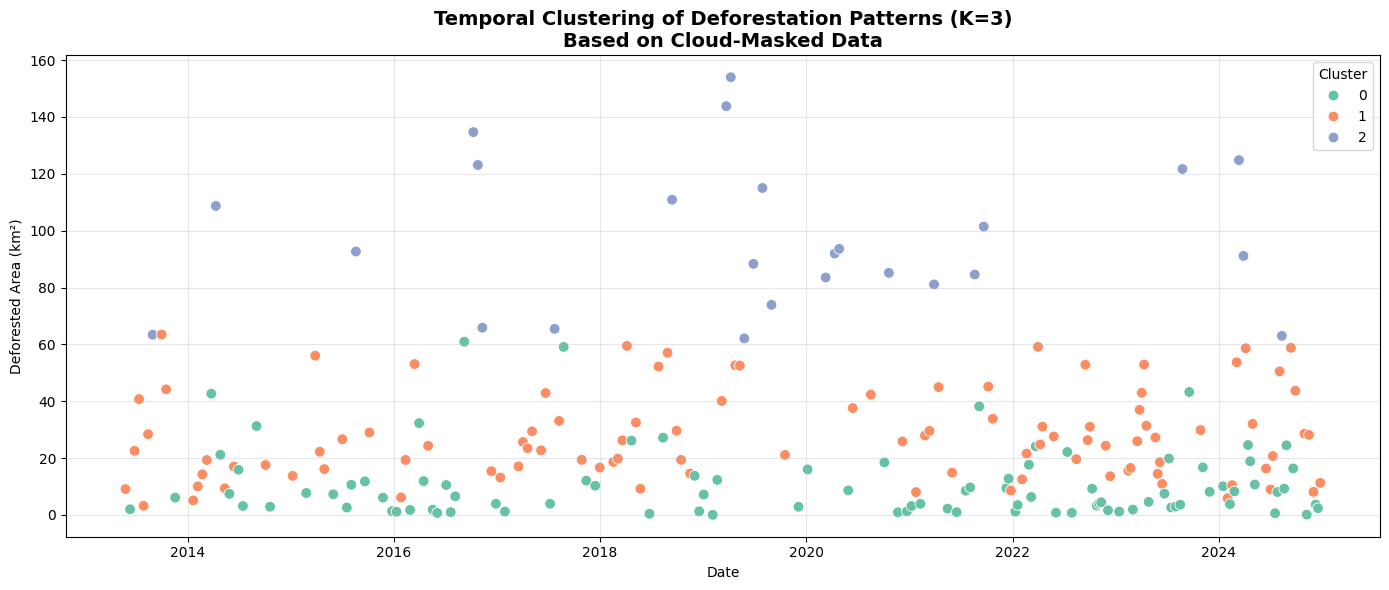

✓ Clustered data saved to: Deforestation_with_Clusters.csv

📊 MODEL COMPARISON SUMMARY
        Model  MAE (km²)  RMSE (km²)        R²
      Prophet  20.160198   29.320143 -0.108573
        ARIMA  21.413950   27.755413  0.006592
Random Forest  13.646668   20.215062  0.473034

🏆 Best Performing Model: Random Forest (RMSE: 20.215 km²)

📈 GENERATING FORECAST VISUALIZATIONS


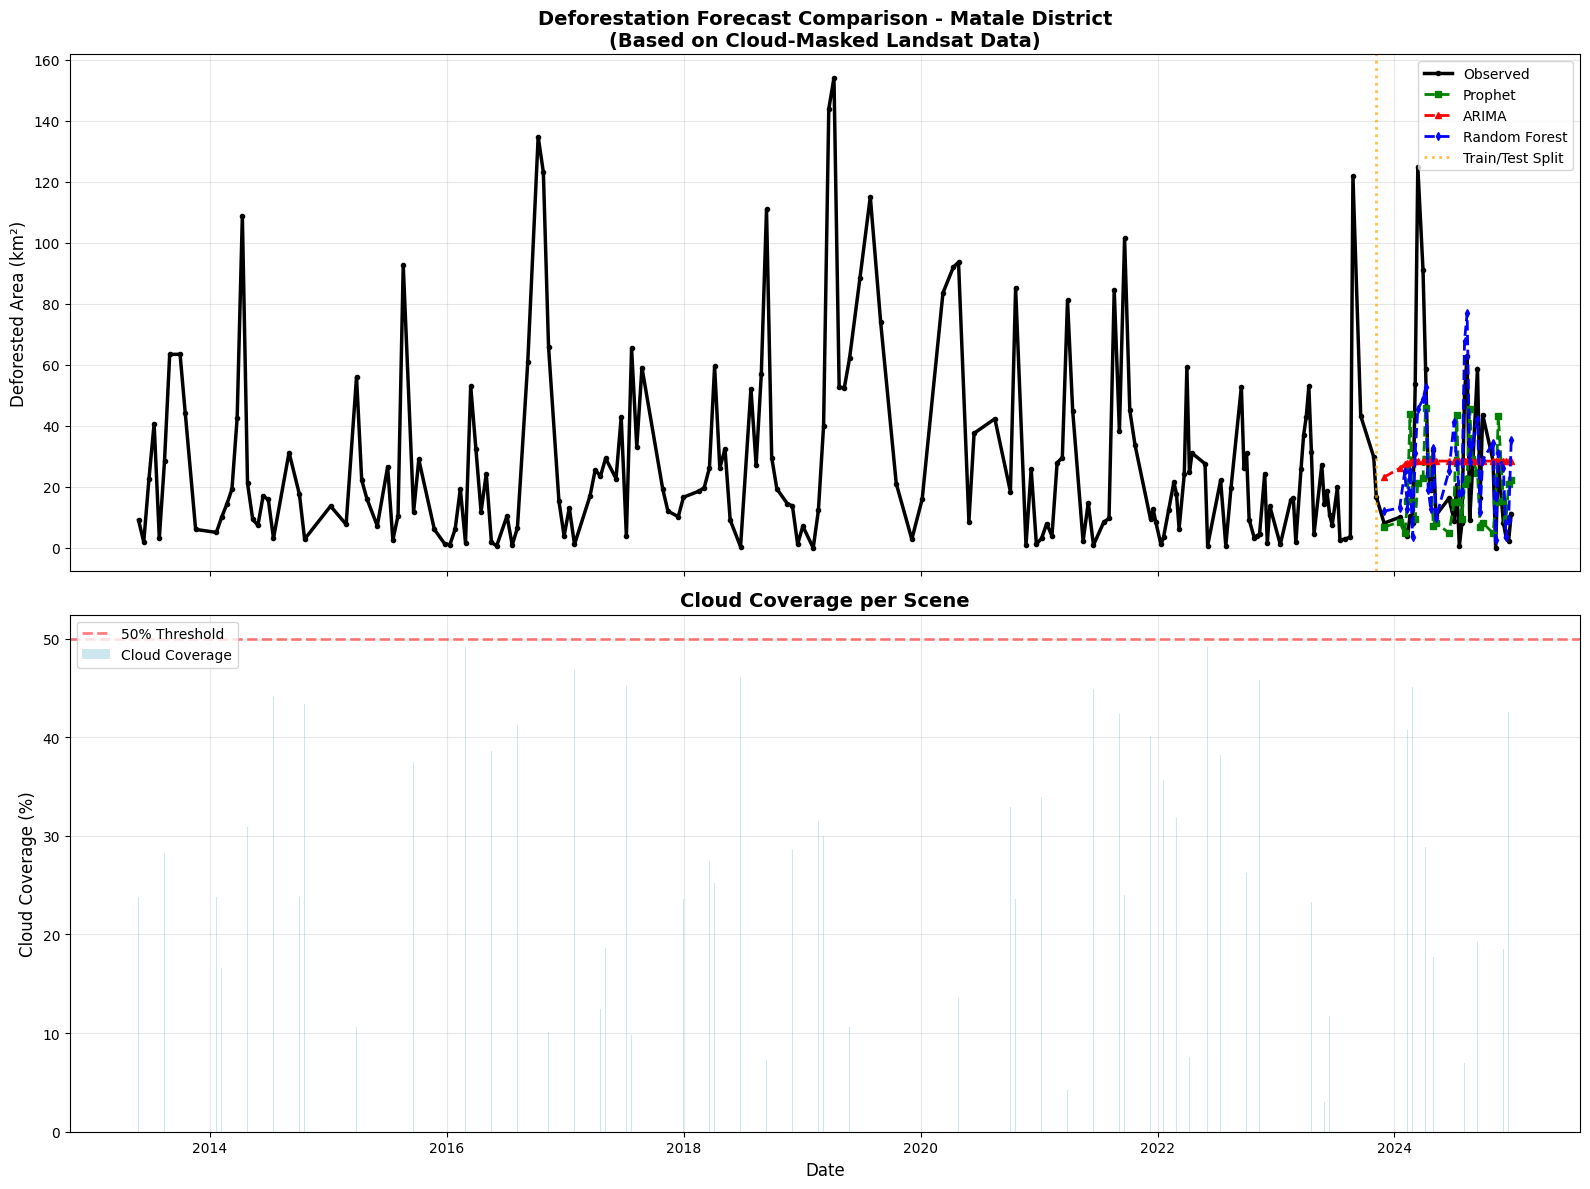

✓ Forecast comparison saved

🔮 GENERATING SHORT-TERM FUTURE PREDICTIONS


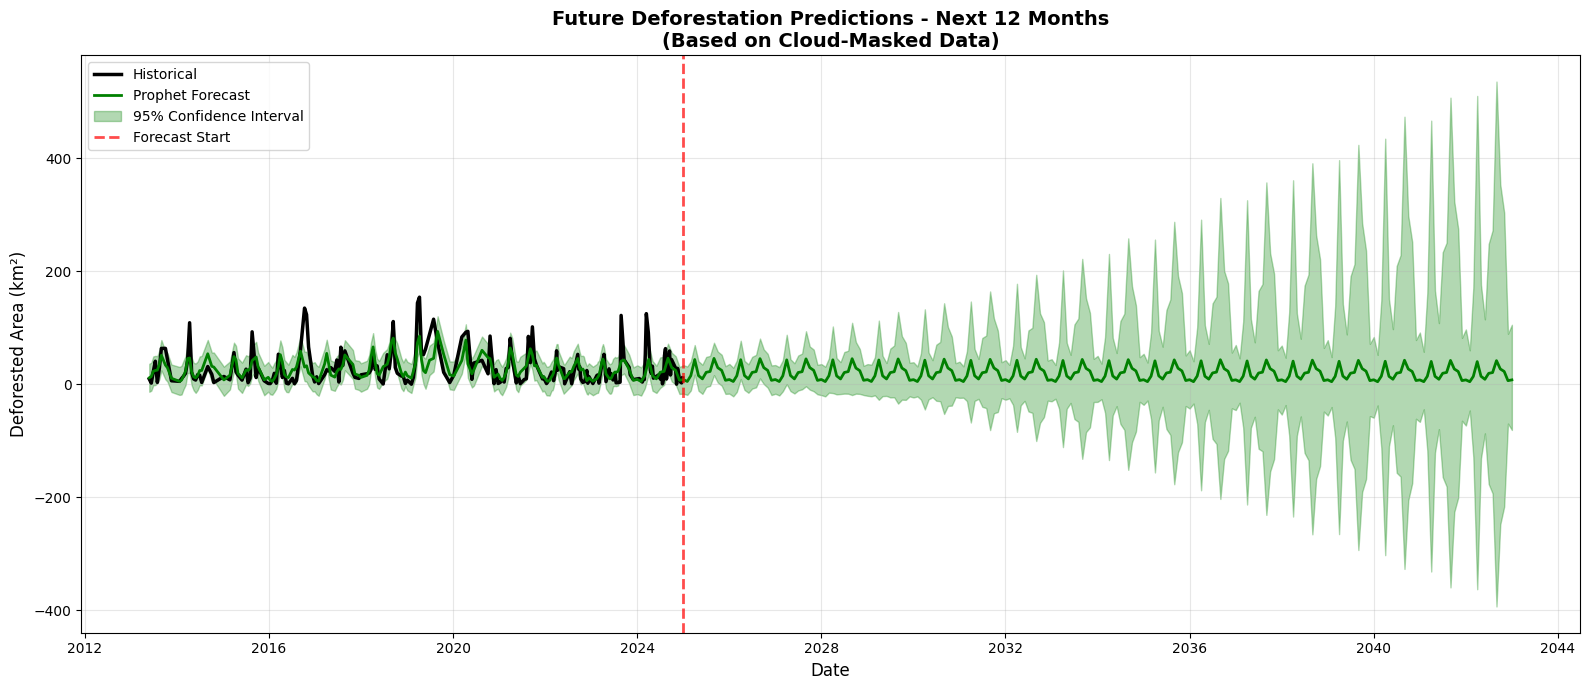

✓ Short-term predictions generated for next 12 months

✅ MODEL COMPARISON AND PREDICTION COMPLETE!
📁 Results saved to: D:\Satellite Image Processing\Deforestation_Matale\Model_Comparison

Generated files:
  • Model_Comparison_Results.csv - Performance metrics
  • KMeans_Temporal_Clusters.png - Clustering visualization
  • Model_Forecast_Comparison.png - Model comparison chart
  • Short_Term_Predictions.png - Future predictions
  • Deforestation_with_Clusters.csv - Data with cluster labels

⛅ Cloud Masking Impact:
  • Models trained on cloud-masked data (avg cloud: 26.4%)
  • Cloud coverage used as additional predictor feature
  • Future predictions assume 26.4% avg cloud coverage


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION
BASE_DIR = r"D:\Satellite Image Processing\Deforestation_Matale"
MONTHLY_FILE = os.path.join(BASE_DIR, "Processed_Monthly", "Monthly_Deforestation_Stats.csv")
CLOUD_FILE = os.path.join(BASE_DIR, "Processed_Monthly", "Cloud_Coverage_Stats.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "Model_Comparison")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*70)
print("DEFORESTATION PREDICTION MODELS - MATALE DISTRICT")
print("(Based on Cloud-Masked Landsat Data)")
print("="*70)

# LOAD DATA WITH CLOUD COVERAGE INFORMATION
def load_deforestation_data():
    """Load deforestation data with cloud coverage metrics"""
    
    if os.path.exists(MONTHLY_FILE):
        print(f"✓ Loading monthly data from: {MONTHLY_FILE}")
        df = pd.read_csv(MONTHLY_FILE, parse_dates=["Date"])
        df = df.sort_values("Date")
        
        # Load cloud coverage data if available
        if os.path.exists(CLOUD_FILE):
            print(f"✓ Loading cloud coverage data from: {CLOUD_FILE}")
            cloud_df = pd.read_csv(CLOUD_FILE, parse_dates=["date"])
            cloud_df = cloud_df.rename(columns={'date': 'Date'})
            
            # Merge with deforestation data
            df = df.merge(cloud_df[['Date', 'cloud_coverage', 'processed']], 
                         on='Date', how='left', suffixes=('', '_cloud'))
            
            # Report cloud coverage statistics
            avg_cloud = df['Cloud_Coverage'].mean() if 'Cloud_Coverage' in df.columns else 0
            print(f"✓ Average cloud coverage: {avg_cloud:.1f}%")
            
            if 'Cloud_Coverage' in df.columns:
                high_cloud_scenes = len(df[df['Cloud_Coverage'] > 50])
                print(f"✓ Scenes with >50% clouds (excluded from original processing): {high_cloud_scenes}")
        else:
            print("⚠ Cloud coverage file not found (older data format)")
        
        print(f"✓ Loaded {len(df)} monthly records ({df['Date'].min().date()} → {df['Date'].max().date()})")
        
        # Add data quality flag based on cloud coverage
        if 'Cloud_Coverage' in df.columns:
            df['Data_Quality'] = 'High'
            df.loc[df['Cloud_Coverage'] > 30, 'Data_Quality'] = 'Medium'
            df.loc[df['Cloud_Coverage'] > 50, 'Data_Quality'] = 'Low'
            
            quality_counts = df['Data_Quality'].value_counts()
            print(f"\n📊 Data Quality Distribution:")
            for quality, count in quality_counts.items():
                print(f"   {quality}: {count} scenes ({count/len(df)*100:.1f}%)")
        
        return df, "monthly"
    else:
        raise FileNotFoundError(f"Data file not found: {MONTHLY_FILE}")

# Load data
df, data_type = load_deforestation_data()

# DATA PREPROCESSING FOR CLOUD-MASKED DATA
print(f"\n" + "="*70)
print("📊 DATA PREPROCESSING & QUALITY FILTERING")
print("="*70)

# Check for valid pixel counts
if 'Valid_Pixels' in df.columns:
    min_valid_pixels = df['Valid_Pixels'].min()
    max_valid_pixels = df['Valid_Pixels'].max()
    avg_valid_pixels = df['Valid_Pixels'].mean()
    print(f"Valid pixels per scene: min={min_valid_pixels:,}, max={max_valid_pixels:,}, avg={avg_valid_pixels:,.0f}")

# Filter out scenes with extremely high cloud coverage (if any slipped through)
original_len = len(df)
if 'Cloud_Coverage' in df.columns:
    df = df[df['Cloud_Coverage'] <= 50].copy()
    removed = original_len - len(df)
    if removed > 0:
        print(f"⚠ Removed {removed} scenes with >50% cloud coverage from modeling dataset")

# Handle any remaining missing values
if df['Deforested_Area_km2'].isna().any():
    missing_count = df['Deforested_Area_km2'].isna().sum()
    print(f"⚠ Found {missing_count} missing values in deforestation data")
    # Use interpolation for missing values
    df['Deforested_Area_km2'] = df['Deforested_Area_km2'].interpolate(method='linear')
    print(f"✓ Applied linear interpolation to fill missing values")

print(f"✓ Final dataset size: {len(df)} scenes")

# TRAIN/TEST SPLIT
train_size = int(len(df) * 0.85)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

y_train, y_test = train_df["Deforested_Area_km2"], test_df["Deforested_Area_km2"]
X_train_index, X_test_index = train_df["Date"], test_df["Date"]

print(f"\n✓ Train/Test Split: {len(train_df)} training, {len(test_df)} testing records")
print(f"  Training period: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"  Testing period: {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")

# 1. PROPHET MODEL
print("\n" + "="*70)
print("🟢 PROPHET MODEL - Time Series Forecasting")
print("="*70)

prophet_df = train_df[["Date", "Deforested_Area_km2"]].rename(columns={"Date": "ds", "Deforested_Area_km2": "y"})

# Add cloud coverage as regressor if available
model_prophet = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.3,
    seasonality_mode='multiplicative'
)

# Add cloud coverage as additional regressor if available
if 'Cloud_Coverage' in train_df.columns:
    prophet_df['cloud_coverage'] = train_df['Cloud_Coverage'].values
    model_prophet.add_regressor('cloud_coverage')
    print("✓ Added cloud coverage as additional regressor")

model_prophet.fit(prophet_df)

# Forecast
freq = "MS"  # Monthly start
future = model_prophet.make_future_dataframe(periods=len(test_df), freq=freq)

# Add cloud coverage for test period if using it as regressor
if 'Cloud_Coverage' in df.columns and 'cloud_coverage' in prophet_df.columns:
    # Use average cloud coverage for future predictions
    avg_cloud_coverage = train_df['Cloud_Coverage'].mean()
    future['cloud_coverage'] = avg_cloud_coverage
    print(f"✓ Using average cloud coverage ({avg_cloud_coverage:.1f}%) for predictions")

forecast = model_prophet.predict(future)
prophet_forecast = forecast.tail(len(test_df))
prophet_pred = prophet_forecast["yhat"].values

# Metrics
prophet_mae = mean_absolute_error(y_test, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(y_test, prophet_pred))
prophet_r2 = r2_score(y_test, prophet_pred)

print(f"✓ Prophet Performance:")
print(f"  MAE:  {prophet_mae:.3f} km²")
print(f"  RMSE: {prophet_rmse:.3f} km²")
print(f"  R²:   {prophet_r2:.3f}")

# 2. ARIMA MODEL
print("\n" + "="*70)
print("🟡 ARIMA MODEL - Autoregressive Integrated Moving Average")
print("="*70)

try:
    arima_model = ARIMA(y_train, order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(y_test))
    
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)
    
    print(f"✓ ARIMA(1,1,1) Performance:")
    print(f"  MAE:  {arima_mae:.3f} km²")
    print(f"  RMSE: {arima_rmse:.3f} km²")
    print(f"  R²:   {arima_r2:.3f}")
    
except Exception as e:
    print(f"⚠ ARIMA model failed: {str(e)}")
    # Fallback to moving average
    window = 12
    arima_forecast = np.full(len(y_test), y_train.rolling(window=window).mean().iloc[-1])
    arima_mae = mean_absolute_error(y_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
    arima_r2 = r2_score(y_test, arima_forecast)
    print(f"✓ Moving Average (fallback) Performance:")
    print(f"  MAE:  {arima_mae:.3f} km²")
    print(f"  RMSE: {arima_rmse:.3f} km²")
    print(f"  R²:   {arima_r2:.3f}")

# 3. RANDOM FOREST MODEL WITH ENHANCED FEATURES
print("\n" + "="*70)
print("🟣 RANDOM FOREST MODEL - Ensemble Machine Learning")
print("="*70)

df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Quarter"] = df["Date"].dt.quarter
df["DayOfYear"] = df["Date"].dt.dayofyear

# Enhanced features including cloud coverage
feature_cols = ["Month", "Year", "Quarter"]

# Add cloud coverage as feature if available
if 'Cloud_Coverage' in df.columns:
    feature_cols.append("Cloud_Coverage")
    print("✓ Added cloud coverage as model feature")

# Add valid pixels as feature if available
if 'Valid_Pixels' in df.columns:
    feature_cols.append("Valid_Pixels")
    print("✓ Added valid pixel count as model feature")

X = df[feature_cols]
y = df["Deforested_Area_km2"]

X_train_rf, X_test_rf = X.iloc[:train_size], X.iloc[train_size:]
y_train_rf, y_test_rf = y.iloc[:train_size], y.iloc[train_size:]

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train_rf, y_train_rf)
rf_pred = rf.predict(X_test_rf)

rf_mae = mean_absolute_error(y_test_rf, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_pred))
rf_r2 = r2_score(y_test_rf, rf_pred)

print(f"✓ Random Forest Performance:")
print(f"  MAE:  {rf_mae:.3f} km²")
print(f"  RMSE: {rf_rmse:.3f} km²")
print(f"  R²:   {rf_r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
print(f"\n  Feature Importance:")
for _, row in feature_importance.iterrows():
    print(f"    {row['Feature']}: {row['Importance']:.3f}")

# 4. K-MEANS CLUSTERING WITH CLOUD AWARENESS
print("\n" + "="*70)
print("⚪ K-MEANS CLUSTERING - Temporal Pattern Discovery")
print("="*70)

# Include cloud coverage in clustering if available
cluster_features = ["Deforested_Area_km2"]
if 'Cloud_Coverage' in df.columns:
    cluster_features.append("Cloud_Coverage")
    print("✓ Including cloud coverage in clustering analysis")

X_scaled = StandardScaler().fit_transform(df[cluster_features])
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

cluster_stats = df.groupby('Cluster')['Deforested_Area_km2'].agg(['mean', 'min', 'max', 'count'])
print("✓ Cluster Statistics (Deforestation):")
print(cluster_stats)

if 'Cloud_Coverage' in df.columns:
    cloud_cluster_stats = df.groupby('Cluster')['Cloud_Coverage'].agg(['mean', 'min', 'max'])
    print("\n✓ Cluster Statistics (Cloud Coverage):")
    print(cloud_cluster_stats)

plt.figure(figsize=(14,6))
sns.scatterplot(x="Date", y="Deforested_Area_km2", hue="Cluster", palette="Set2", data=df, s=60)
plt.title("Temporal Clustering of Deforestation Patterns (K=3)\nBased on Cloud-Masked Data", 
          fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Deforested Area (km²)")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "KMeans_Temporal_Clusters.png"), dpi=200)
plt.show()

df.to_csv(os.path.join(OUTPUT_DIR, "Deforestation_with_Clusters.csv"), index=False)
print(f"✓ Clustered data saved to: Deforestation_with_Clusters.csv")

# 5. MODEL COMPARISON
print("\n" + "="*70)
print("📊 MODEL COMPARISON SUMMARY")
print("="*70)

results = pd.DataFrame({
    "Model": ["Prophet", "ARIMA", "Random Forest"],
    "MAE (km²)": [prophet_mae, arima_mae, rf_mae],
    "RMSE (km²)": [prophet_rmse, arima_rmse, rf_rmse],
    "R²": [prophet_r2, arima_r2, rf_r2]
})

print(results.to_string(index=False))

# Choose best model by RMSE
best_model = results.loc[results["RMSE (km²)"].idxmin(), "Model"]
best_rmse = results.loc[results["RMSE (km²)"].idxmin(), "RMSE (km²)"]
print(f"\n🏆 Best Performing Model: {best_model} (RMSE: {best_rmse:.3f} km²)")

results.to_csv(os.path.join(OUTPUT_DIR, "Model_Comparison_Results.csv"), index=False)

# 6. VISUALIZE FORECASTS WITH CLOUD INFO
print("\n" + "="*70)
print("📈 GENERATING FORECAST VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Plot 1: Deforestation forecasts
axes[0].plot(df["Date"], df["Deforested_Area_km2"], label="Observed", 
            color="black", linewidth=2.5, marker='o', markersize=3)
axes[0].plot(X_test_index, prophet_pred, "g--", label="Prophet", linewidth=2, marker='s', markersize=4)
axes[0].plot(X_test_index, arima_forecast, "r--", label="ARIMA", linewidth=2, marker='^', markersize=4)
axes[0].plot(X_test_index, rf_pred, "b--", label="Random Forest", linewidth=2, marker='d', markersize=4)
axes[0].axvline(x=train_df['Date'].max(), color='orange', linestyle=':', linewidth=2, alpha=0.7, 
               label='Train/Test Split')
axes[0].set_title("Deforestation Forecast Comparison - Matale District\n(Based on Cloud-Masked Landsat Data)", 
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel("Deforested Area (km²)", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Cloud coverage over time
if 'Cloud_Coverage' in df.columns:
    axes[1].bar(df["Date"], df["Cloud_Coverage"], color='lightblue', alpha=0.6, label='Cloud Coverage')
    axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50% Threshold')
    axes[1].set_title("Cloud Coverage per Scene", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Date", fontsize=12)
    axes[1].set_ylabel("Cloud Coverage (%)", fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
else:
    # If no cloud data, show residuals instead
    axes[1].plot(X_test_index, y_test.values - prophet_pred, 'g-', label='Prophet Residuals', alpha=0.7)
    axes[1].plot(X_test_index, y_test.values - arima_forecast, 'r-', label='ARIMA Residuals', alpha=0.7)
    axes[1].plot(X_test_index, y_test.values - rf_pred, 'b-', label='RF Residuals', alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1].set_title("Model Prediction Residuals", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Date", fontsize=12)
    axes[1].set_ylabel("Residual (km²)", fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Model_Forecast_Comparison.png"), dpi=200)
plt.show()

print("✓ Forecast comparison saved")

# 7. FUTURE PREDICTIONS (CLOUD-AWARE)
print("\n" + "="*70)
print("🔮 GENERATING SHORT-TERM FUTURE PREDICTIONS")
print("="*70)

future_periods = 12  # 12 months ahead
future_df = model_prophet.make_future_dataframe(periods=len(df) + future_periods, freq=freq)

# Add average cloud coverage for future predictions if using it as regressor
if 'Cloud_Coverage' in df.columns and 'cloud_coverage' in prophet_df.columns:
    future_df['cloud_coverage'] = train_df['Cloud_Coverage'].mean()

future_forecast = model_prophet.predict(future_df)

plt.figure(figsize=(16,7))
plt.plot(df["Date"], df["Deforested_Area_km2"], label="Historical", color="black", linewidth=2.5)
plt.plot(future_forecast["ds"], future_forecast["yhat"], "g-", label="Prophet Forecast", linewidth=2)
plt.fill_between(future_forecast["ds"], 
                future_forecast["yhat_lower"], 
                future_forecast["yhat_upper"], 
                alpha=0.3, color="green", label="95% Confidence Interval")
plt.axvline(x=df["Date"].max(), color="red", linestyle="--", linewidth=2, alpha=0.7, label="Forecast Start")
plt.title("Future Deforestation Predictions - Next 12 Months\n(Based on Cloud-Masked Data)", 
         fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Deforested Area (km²)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Short_Term_Predictions.png"), dpi=200)
plt.show()

print(f"✓ Short-term predictions generated for next {future_periods} months")

print("\n" + "="*70)
print("✅ MODEL COMPARISON AND PREDICTION COMPLETE!")
print("="*70)
print(f"📁 Results saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
print("  • Model_Comparison_Results.csv - Performance metrics")
print("  • KMeans_Temporal_Clusters.png - Clustering visualization")
print("  • Model_Forecast_Comparison.png - Model comparison chart")
print("  • Short_Term_Predictions.png - Future predictions")
print("  • Deforestation_with_Clusters.csv - Data with cluster labels")

if 'Cloud_Coverage' in df.columns:
    print("\n⛅ Cloud Masking Impact:")
    print(f"  • Models trained on cloud-masked data (avg cloud: {df['Cloud_Coverage'].mean():.1f}%)")
    print(f"  • Cloud coverage used as additional predictor feature")
    print(f"  • Future predictions assume {train_df['Cloud_Coverage'].mean():.1f}% avg cloud coverage")


🔮 LONG-TERM FORECAST (2026-2030) - PROPHET MODEL
(Accounting for Cloud Coverage Patterns)
✓ Using historical average cloud coverage (26.4%) for long-term predictions

📍 Projected Deforested Area in 2030: 6.72 km²
   Date: 2030-12-01
   95% Confidence Interval: [-24.87, 36.48] km²
   Uncertainty Range: ±29.76 km²

📊 Projected Change from Current (2024-12-26):
   Current: 11.25 km²
   2030 Projection: 6.72 km²
   Increase: -4.52 km² (-40.2%)

📍 Projected Deforested Area in 2030: 6.72 km²
   Date: 2030-12-01
   95% Confidence Interval: [-24.87, 36.48] km²
   Uncertainty Range: ±29.76 km²

📊 Projected Change from Current (2024-12-26):
   Current: 11.25 km²
   2030 Projection: 6.72 km²
   Increase: -4.52 km² (-40.2%)


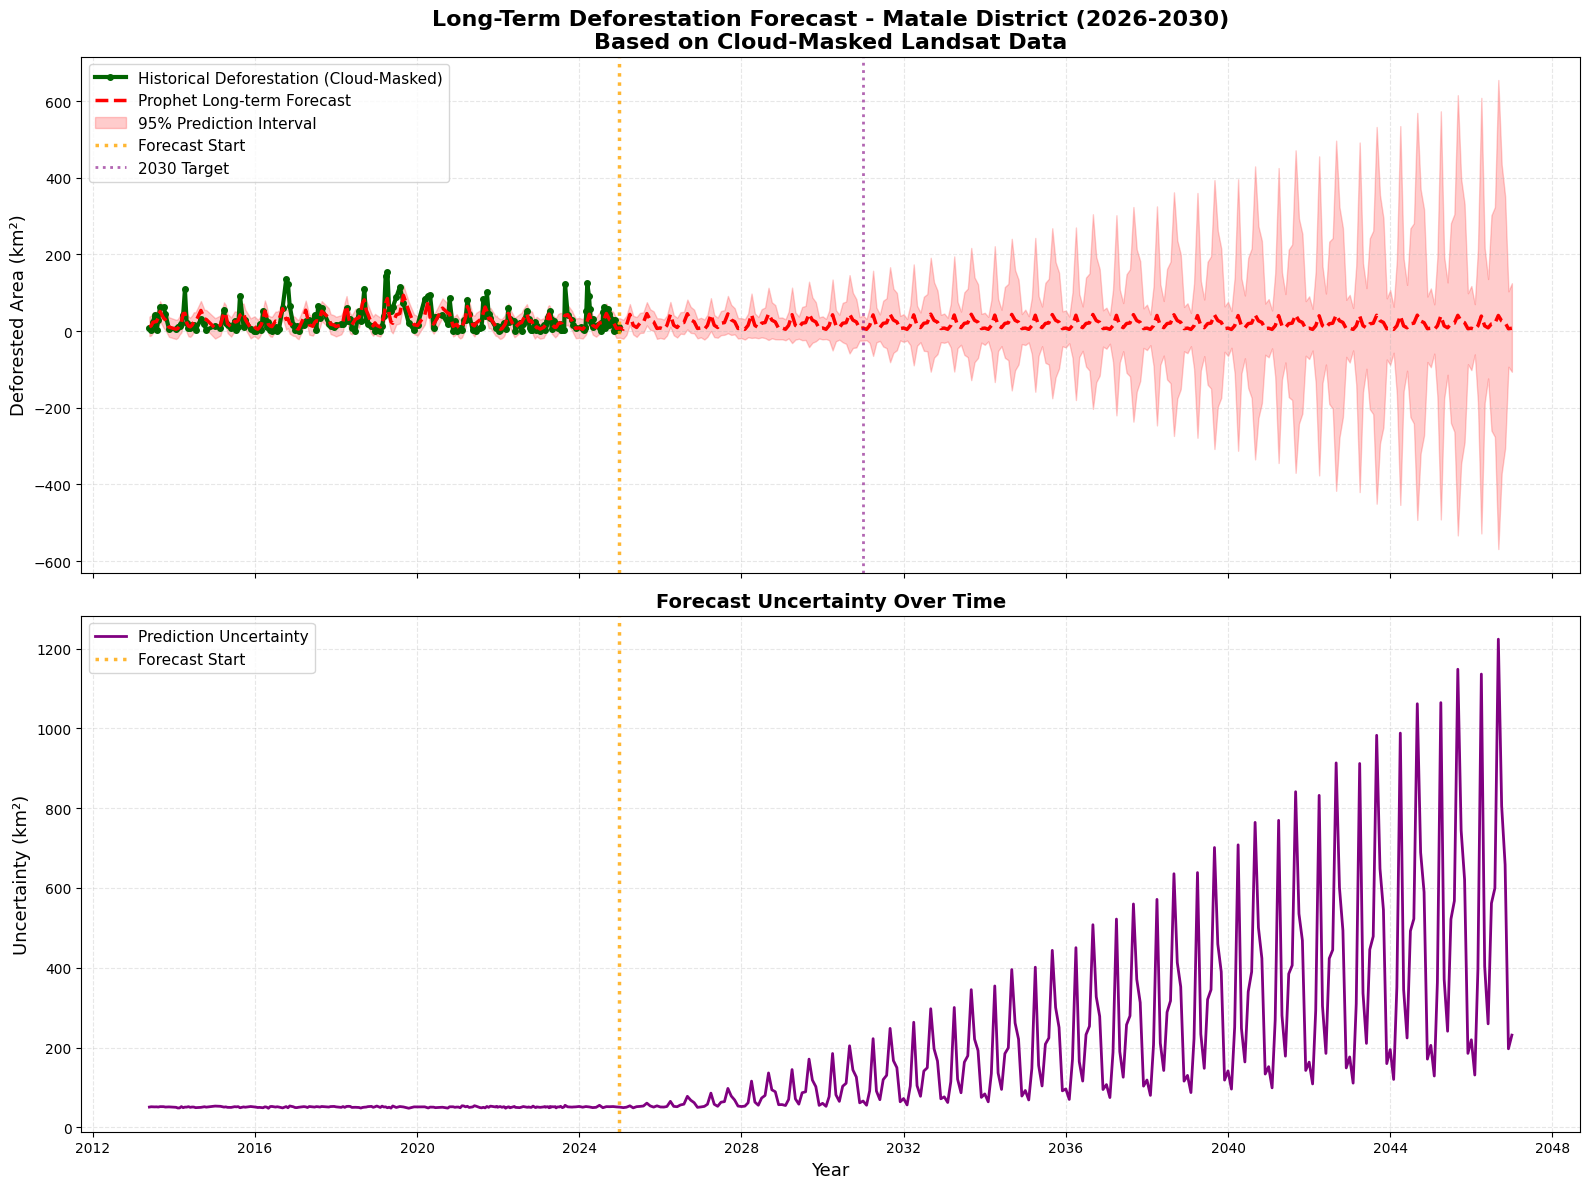

✓ Long-term forecast visualization saved
✓ Forecast data exported to: Deforestation_Forecast_2030.csv

🎯 SCENARIO ANALYSIS - DEFORESTATION TRAJECTORIES

📈 Yearly Deforestation Projections (2026-2030):
 Year      yhat  yhat_lower  yhat_upper
 2025 20.537159   -5.352263   47.035856
 2026 20.438965   -8.781757   49.062828
 2027 20.340742  -12.445473   52.696163
 2028 20.245478  -19.068248   58.420035
 2029 20.140456  -25.224108   64.523131
 2030 20.042244  -33.126715   72.681844
 2031 19.944003  -41.311624   81.440169
 2032 19.848660  -51.123175   90.431793
 2033 19.743753  -60.468953  100.871052
 2034 19.645523  -72.007366  111.963273
 2035 19.547265  -82.584321  124.613536
 2036 19.451843  -94.283167  135.761856
 2037 19.347051 -108.981471  148.551671
 2038 19.248802 -124.298823  163.356335
 2039 19.150526 -138.663165  177.489492
 2040 19.055025 -153.895212  192.721058
 2041 18.950348 -168.875506  208.303796
 2042 18.852081 -186.264579  222.926772
 2043 18.753787 -203.143802  239.775712

In [3]:
# LONG-TERM FUTURE PROJECTIONS (2026-2030) WITH CLOUD CONSIDERATIONS
print("\n" + "="*70)
print("🔮 LONG-TERM FORECAST (2026-2030) - PROPHET MODEL")
print("(Accounting for Cloud Coverage Patterns)")
print("="*70)

# Extended prediction: 5 years ahead (60 months)
long_term_periods = 60
long_term_future = model_prophet.make_future_dataframe(periods=len(df) + long_term_periods, freq=freq)

# Add cloud coverage for long-term predictions if using it as regressor
if 'Cloud_Coverage' in df.columns and 'cloud_coverage' in prophet_df.columns:
    avg_cloud = train_df['Cloud_Coverage'].mean()
    long_term_future['cloud_coverage'] = avg_cloud
    print(f"✓ Using historical average cloud coverage ({avg_cloud:.1f}%) for long-term predictions")

long_term_forecast = model_prophet.predict(long_term_future)

# Extract future data only
future_only = long_term_forecast[long_term_forecast["ds"] > df["Date"].max()]

# Calculate 2030 projection
projection_2030 = future_only[future_only["ds"] <= "2030-12-31"]

if len(projection_2030) > 0:
    final_2030 = projection_2030.iloc[-1]
    print(f"\n📍 Projected Deforested Area in 2030: {final_2030['yhat']:.2f} km²")
    print(f"   Date: {final_2030['ds'].date()}")
    print(f"   95% Confidence Interval: [{final_2030['yhat_lower']:.2f}, {final_2030['yhat_upper']:.2f}] km²")
    print(f"   Uncertainty Range: ±{final_2030['yhat_upper'] - final_2030['yhat']:.2f} km²")
    
    # Calculate increase from current
    current_deforestation = df['Deforested_Area_km2'].iloc[-1]
    increase = final_2030['yhat'] - current_deforestation
    increase_pct = (increase / current_deforestation) * 100
    print(f"\n📊 Projected Change from Current ({df['Date'].max().date()}):")
    print(f"   Current: {current_deforestation:.2f} km²")
    print(f"   2030 Projection: {final_2030['yhat']:.2f} km²")
    print(f"   Increase: {increase:.2f} km² ({increase_pct:+.1f}%)")

# VISUALIZATION
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Plot 1: Deforestation forecast
axes[0].plot(df["Date"], df["Deforested_Area_km2"], 
            label="Historical Deforestation (Cloud-Masked)", 
            color="darkgreen", linewidth=3, marker='o', markersize=4)

axes[0].plot(long_term_forecast["ds"], long_term_forecast["yhat"], 
            label="Prophet Long-term Forecast", 
            color="red", linewidth=2.5, linestyle='--')

axes[0].fill_between(long_term_forecast["ds"], 
                     long_term_forecast["yhat_lower"], 
                     long_term_forecast["yhat_upper"], 
                     alpha=0.2, color="red", label="95% Prediction Interval")

# Mark forecast start
axes[0].axvline(x=df["Date"].max(), color="orange", linestyle=":", 
               linewidth=2.5, alpha=0.8, label="Forecast Start")

# Mark 2030
axes[0].axvline(x=pd.to_datetime("2030-12-31"), color="purple", 
               linestyle=":", linewidth=2, alpha=0.6, label="2030 Target")

axes[0].set_title("Long-Term Deforestation Forecast - Matale District (2026-2030)\nBased on Cloud-Masked Landsat Data", 
                 fontsize=16, fontweight='bold')
axes[0].set_ylabel("Deforested Area (km²)", fontsize=13)
axes[0].legend(fontsize=11, loc='upper left')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Plot 2: Uncertainty over time
uncertainty = long_term_forecast["yhat_upper"] - long_term_forecast["yhat_lower"]
axes[1].plot(long_term_forecast["ds"], uncertainty, 
            color="purple", linewidth=2, label="Prediction Uncertainty")
axes[1].axvline(x=df["Date"].max(), color="orange", linestyle=":", 
               linewidth=2.5, alpha=0.8, label="Forecast Start")
axes[1].set_title("Forecast Uncertainty Over Time", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Year", fontsize=13)
axes[1].set_ylabel("Uncertainty (km²)", fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Deforestation_Forecast_2030.png"), dpi=200, bbox_inches='tight')
plt.show()

print("✓ Long-term forecast visualization saved")

# Save forecast data
forecast_export = long_term_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
forecast_export["uncertainty"] = forecast_export["yhat_upper"] - forecast_export["yhat_lower"]
forecast_export = forecast_export.rename(
    columns={"ds": "Date", "yhat": "Predicted_Deforested_Area_km2", 
             "yhat_lower": "Lower_Bound_km2", "yhat_upper": "Upper_Bound_km2",
             "uncertainty": "Prediction_Uncertainty_km2"}
)

# Add data source note
forecast_export["Data_Source"] = "Cloud-Masked Landsat Collection 2"
if 'Cloud_Coverage' in df.columns:
    forecast_export["Assumed_Cloud_Coverage_Pct"] = train_df['Cloud_Coverage'].mean()

forecast_export.to_csv(os.path.join(OUTPUT_DIR, "Deforestation_Forecast_2030.csv"), index=False)

print("✓ Forecast data exported to: Deforestation_Forecast_2030.csv")

# SCENARIO ANALYSIS
print("\n" + "="*70)
print("🎯 SCENARIO ANALYSIS - DEFORESTATION TRAJECTORIES")
print("="*70)

# Calculate yearly averages from forecast
forecast_yearly = long_term_forecast.copy()
forecast_yearly['Year'] = forecast_yearly['ds'].dt.year
yearly_forecast = forecast_yearly[forecast_yearly['ds'] > df['Date'].max()].groupby('Year').agg({
    'yhat': 'mean',
    'yhat_lower': 'mean',
    'yhat_upper': 'mean'
}).reset_index()

print("\n📈 Yearly Deforestation Projections (2026-2030):")
print(yearly_forecast.to_string(index=False))

# Calculate cumulative deforestation increase
cumulative_increase = []
baseline = df['Deforested_Area_km2'].iloc[-1]

for _, row in yearly_forecast.iterrows():
    year_increase = row['yhat'] - baseline
    cumulative_increase.append({
        'Year': int(row['Year']),
        'Projected_Area_km2': row['yhat'],
        'Cumulative_Increase_km2': year_increase,
        'Cumulative_Increase_Pct': (year_increase / baseline) * 100
    })

cumulative_df = pd.DataFrame(cumulative_increase)
print("\n📊 Cumulative Deforestation Increase (from current):")
print(cumulative_df.to_string(index=False))

cumulative_df.to_csv(os.path.join(OUTPUT_DIR, "Yearly_Projections_2030.csv"), index=False)
print("\n✓ Yearly projections saved to: Yearly_Projections_2030.csv")

print("\n" + "="*70)
print("✅ LONG-TERM FORECASTING COMPLETE")
print("="*70)
print(f"📈 All results saved to: {OUTPUT_DIR}")

print("\n🌲 Use these forecasts to:")
print("   • Plan forest conservation interventions")
print("   • Identify high-risk deforestation zones")
print("   • Set realistic reforestation targets")
print("   • Monitor progress against projected trends")
print("   • Allocate conservation resources effectively")

if 'Cloud_Coverage' in df.columns:
    print("\n⛅ Cloud Masking Impact on Predictions:")
    print(f"   • Historical data filtered for <50% cloud coverage")
    print(f"   • Average cloud coverage: {df['Cloud_Coverage'].mean():.1f}%")
    print(f"   • Predictions assume similar cloud patterns continue")
    print(f"   • Uncertainty bands account for data quality variation")

print("\n⚠️  Important Notes:")
print("   • Forecasts based on historical trends continuing")
print("   • Major policy changes or interventions may alter trajectory")
print("   • Cloud-masked data provides more accurate baseline")
print("   • Monitor actual vs. predicted to validate model performance")
print("="*70)